deep learning with python

3.6 predicting house prices: a regression example

In [1]:
from keras.datasets import boston_housing
from keras import models, layers, optimizers, losses, metrics
import numpy as np
import matplotlib.pyplot as viz

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
mu = train_data.mean(axis=0)
sigma = train_data.std(axis=0)
train_data = (train_data - mu)/sigma
test_data = (test_data - mu)/sigma

build the model

hyperparameters:
* architecture:
    - number of hidden layers
    - number of units in each hidden layer
* optimization:
    - learning rate

In [4]:
def build_model(num_units=None, learning_rate=0.001):
    model = models.Sequential()
    if num_units is not None:
        num_layers = len(num_units)
        # input layer
        num_features = train_data.shape[1]
        model.add(layers.Dense(num_units[0], activation='relu', input_shape=(num_features,)))
        # hidden layers
        for i in range(1, num_layers - 1):
            model.add(layers.Dense(num_units[i], activation='relu'))
        # output layer
        model.add(layers.Dense(num_units[-1]))

        model.compile(optimizer=optimizers.RMSprop(lr=learning_rate),
                      loss=losses.mae,
                      metrics=[metrics.mae])
    return model

tune the model

use K-fold cross validation: validation set is small, so validation scores have high variance. train K models using different parts of training data as validation set and average the scores.

hyperparameters:

- batch size
- number of epochs

In [38]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 80
mae_histories = []
for i in range(k):
    print('-> processing fold #{}'.format(i))
    validation_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    validation_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[: i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples :]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[: i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples :]],
                                           axis=0)
    model = build_model(num_units=[64, 32, 1], learning_rate=0.001)
    mae_history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(validation_data, validation_targets),
                            epochs=num_epochs, batch_size=1, verbose=0).history['val_mean_absolute_error']
    mae_histories.append(mae_history)
average_mae_history = np.mean(mae_histories, axis=0)

-> processing fold #0
-> processing fold #1
-> processing fold #2
-> processing fold #3


smooth average validation mae curve and remove first 10 points as they are too big compared to the rest

In [39]:
def smooth_exp_moving_average(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous_point = smoothed_points[-1]
            smoothed_points.append(previous_point * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

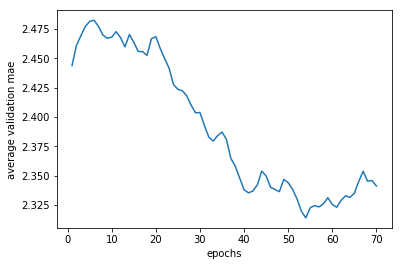

In [40]:
smooth_mae_history = smooth_exp_moving_average(average_mae_history[10:])
viz.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
viz.xlabel("epochs")
viz.ylabel("average validation mae")
viz.show()

final model
(seems like (64, 64) dense layer is the best configuration in this case)

In [63]:
model = build_model(num_units=[64, 64, 1], learning_rate=0.001)
model.fit(train_data, train_targets, epochs=60, batch_size=16)

Epoch 1/60
404/404 [==============================] - 1s 2ms/step - loss: 20.2000 - mean_absolute_error: 20.2000
Epoch 2/60
404/404 [==============================] - 0s 178us/step - loss: 15.1818 - mean_absolute_error: 15.1818
Epoch 3/60
404/404 [==============================] - 0s 212us/step - loss: 8.8558 - mean_absolute_error: 8.8558
Epoch 4/60
404/404 [==============================] - 0s 189us/step - loss: 5.1041 - mean_absolute_error: 5.1041
Epoch 5/60
404/404 [==============================] - 0s 225us/step - loss: 3.9303 - mean_absolute_error: 3.9303
Epoch 6/60
404/404 [==============================] - 0s 199us/step - loss: 3.3910 - mean_absolute_error: 3.3910
Epoch 7/60
404/404 [==============================] - 0s 212us/step - loss: 3.1181 - mean_absolute_error: 3.1181
Epoch 8/60
404/404 [==============================] - 0s 234us/step - loss: 2.9665 - mean_absolute_error: 2.9665
Epoch 9/60
404/404 [==============================] - 0s 183us/step - loss: 2.8329 - mean_abso

In [64]:
model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 4ms/step


[2.950055290670956, 2.950055290670956]